### Importing libraries

In [1]:
#importing modules

import xgboost

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import spacy

from nltk import word_tokenize

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Phrases

import tomotopy as tp

from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.naive_bayes import MultinomialNB


from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

### Importing Dataset

In [2]:
#looking at the raw data

df = pd.read_csv("train.csv")
df.head(5)

,label,text
0,0,Batch #5\n\nAppearance: Pours a slightly hazy ...
1,0,Murky peach color with off-white head. Aroma h...
2,0,Can poured into a Spiegelau IPA glass\n\nA: Po...
3,0,A big thanks to Jeff for this one. 750ml cappe...
4,0,On tap into a shaker pint.\n\nAppearance is go...


## 1. Turning text reviews into numerical vectors

We decided to try a following vector representation: reduced dimensionality TF-IDF, Doc2Vec embedding, Topic probabilities


We made a reasonable restriction for all of these representation to be the same size, say k, so the whole represenation of the text is a 3k vector. We further tested some of the values for k, and came up with k = 50 as giving quite parsimonious represenations and good results. 

In [3]:
#setting sizes here

d2v_size = 50
c_vec_size = 50
topic_size = 50

In [4]:
#loading spacy language model

nlp = spacy.load("en_core_web_lg")

### 1.0.1 Preprocessing (1/2)

Getting rid of numbers, punctuation, stop words, empty lines, emails, URL and too much spaces. Then keeping only lemmas.

In [5]:
import re

def preprocessing_fn(df):
    docs_tokens = []
    indexes_to_drop = []  # remembering indexes to drop empty reviews
    for index, row in df.iterrows():   
        tmp_tokens = []
        # Remove emails and URLs from the text
        doc = re.sub(r'\S+@\S+', '', row["text"])  # Remove emails
        doc = re.sub(r'http\S+', '', doc)  # Remove URLs
        doc = " ".join(doc.replace("\n", "").replace("<s/>", "").replace("\"","").lower().split())
        tmp_tokens = [
            token.lemma_
            for token in nlp(doc)
            if not token.is_stop
            and not token.is_punct
            and not token.like_num
        ]
        if tmp_tokens:
            docs_tokens.append(tmp_tokens)
        else:
            indexes_to_drop.append(index)

    df_clean = df.drop(index=indexes_to_drop)  # dropping empty reviews
    return docs_tokens, df_clean

doc_tkns_train, df_clean_train = preprocessing_fn(df)
# doc_tkns_test, df_clean_test = preprocessing_fn(df_test)


In [6]:
df_clean_train.set_index(np.arange(0, len(df_clean_train["text"]), 1), inplace=True)

### 1.0.2 Preprocessing (2/2)
Accounting for common phrases, using gensim Phrases.

In [7]:
bigram = Phrases(                              
        doc_tkns_train,
        min_count=50,
        threshold=5,
        max_vocab_size=50000
    )

trigram = Phrases(                            
        bigram[doc_tkns_train],
        min_count=50,
        threshold=5,
        max_vocab_size=50000
    )

In [8]:
docs_phrased = [trigram[bigram[line]] for line in doc_tkns_train]

### 1.1 Getting Doc2Vec embeddings

In [9]:

tgd_reviews_train = [TaggedDocument(tkn, [i]) for i, tkn in enumerate(docs_phrased)]

In [10]:
d2v_model = Doc2Vec(tgd_reviews_train, vector_size = d2v_size, window = 2, min_count = 1, workers = 4, epochs = 40)

In [11]:
d2v_model.save("d2v_model_final")

In [12]:
d2v_model = Doc2Vec.load("d2v_model_final")

d2v_vectors = np.array([d2v_model.dv[i] for i in range(len(d2v_model.dv))]).reshape(len(df_clean_train["text"]), d2v_size)

In [13]:
# applying MinMaxScaling, as most linear classifiers work best on scaled data, and some of them require positive features

d2v_vectors = MinMaxScaler().fit_transform(d2v_vectors)
d2v_vectors = pd.DataFrame(d2v_vectors, columns = ["x{}".format(i) for i in range(1, d2v_size + 1)])

### 1.2 Getting Topic Distributions

Here We tested multiple numbers of topics, and allthough the max coherence was achieved not on k=50, the difference was not significant in our opinion, while lower number (50) of topics provide less sparce vectors and more parsimonius representation. 

In [14]:

corpus = tp.utils.Corpus() 

for item in docs_phrased:                    
        corpus.add_doc(words=item)

In [15]:
scores = {}

# training of LDA topic modeling with numbers of topics ranging from 10 to 100 with 10 increments

for topic_num in range(10, 110, 10):
    mdl = tp.LDAModel(k = topic_num, corpus = corpus, min_df=5, rm_top=5, seed = 123)
    mdl.train(0)
    
    # each model is trained on 40 epochs
    
    for i in range(0, 40, 20):
        mdl.train(10)
    scores[topic_num] = tp.coherence.Coherence(mdl, coherence="u_mass").get_score()
    
    # saving all the models for future use
    mdl.save("k_{}".format(topic_num), True)

C:\Users\karti\AppData\Local\Temp\ipykernel_20316\138154953.py:9: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  mdl.train(0)
C:\Users\karti\AppData\Local\Temp\ipykernel_20316\138154953.py:14: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  mdl.train(10)


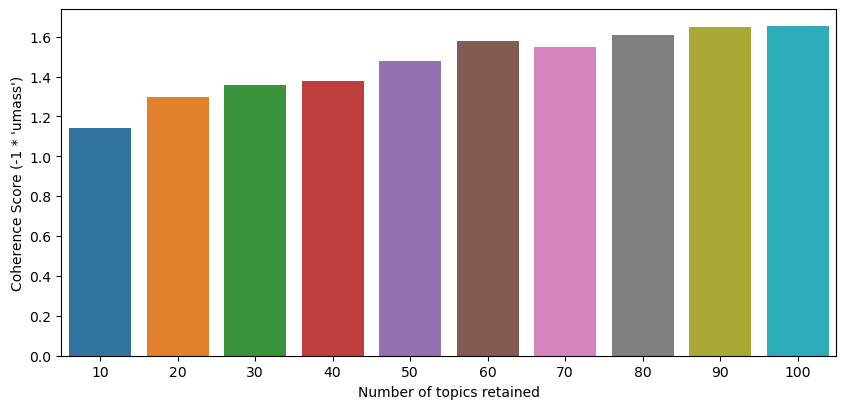

In [16]:
# Vizualising inverse coherence metrics (higher is better) for LDA models with different number of topics

fig = plt.figure(figsize=(10, 4.5))
ax = fig.add_subplot(111)
sns.barplot(x=list(scores.keys()), y=[-1*score for score in scores.values()], ax=ax)
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence Score (-1 * 'umass')")
plt.show()

In [17]:
# Loading a model for k=topic_size topics model and putting distributions into DataFrame

best_mdl = tp.LDAModel.load("k_{}".format(topic_size))
topic_dist = pd.DataFrame(                                                
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
topic_dist.head(2)


,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49,topic_50
0,0.002442,0.002664,0.066542,0.002762,0.002457,0.002676,0.002393,0.002381,0.002252,0.002505,...,0.002536,0.002294,0.002457,0.023516,0.002610,0.365300,0.002859,0.002291,0.002112,0.002660
1,0.003833,0.004183,0.003878,0.004337,0.137987,0.205396,0.003757,0.003739,0.003536,0.003933,...,0.003982,0.003602,0.003858,0.003389,0.004098,0.070554,0.038021,0.003597,0.003315,0.004176


### 1.3 Getting TFIDF with reduced dimensionality

In [19]:
docs_phrased_str = [" ".join(doc) for doc in docs_phrased]

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the preprocessed text and labels into a format that can be used by the classifier
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=0.8, max_features=10000)


In [21]:
c_vectors = vectorizer.fit_transform(docs_phrased_str)

In [22]:
# using truncated SVD to find dimension reduced vectors, truncated SVD works with sparse vectors, which TFIDF vectors are

svd = TruncatedSVD(n_components=c_vec_size, n_iter=10, random_state=123)

In [23]:
c_vectors = svd.fit_transform(c_vectors)

In [24]:
# applying MinMaxScaler to reduced dim. TFIDF vectors

c_vectors = MinMaxScaler().fit_transform(c_vectors)
c_vectors = pd.DataFrame(c_vectors, columns = ["c{}".format(i) for i in range(1, c_vec_size + 1)])

In [25]:
# getting all the vectors together to form final vector representation

data = pd.concat([c_vectors, d2v_vectors, topic_dist], axis=1, join = "inner")

data.head(2)

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49,topic_50
0,0.287391,0.331234,0.272307,0.806807,0.506503,0.429307,0.310766,0.307042,0.263885,0.527763,...,0.002536,0.002294,0.002457,0.023516,0.002610,0.365300,0.002859,0.002291,0.002112,0.002660
1,0.438792,0.224583,0.194151,0.687349,0.493950,0.454487,0.368918,0.261627,0.424187,0.462592,...,0.003982,0.003602,0.003858,0.003389,0.004098,0.070554,0.038021,0.003597,0.003315,0.004176


In [26]:
labels = pd.DataFrame(df_clean_train["label"])

labels.set_index(np.arange(0, len(df_clean_train["label"]), 1))

,label
0,0
1,0
2,0
3,0
4,0
...,...
21039,2
21040,2
21041,2
21042,2


## 2. Different classifiers


###### Classification using just TFIDF

In [110]:
X = c_vectors
y = labels

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [111]:
# Train the classifier
classifier = LogisticRegression(max_iter=10000,solver='saga')

classifier.fit(X_train, y_train['label'])

# Make predictions on the validation set
y_pred = classifier.predict(X_val)

# Compute the F1 score
f1 = f1_score(y_val['label'], y_pred, average='macro')

print(f'F1 Score: {f1}')


F1 Score: 0.5460540135564503


In [112]:
classifier = SVC()
classifier.fit(X_train, y_train['label'])

# Make predictions on the validation set
y_pred = classifier.predict(X_val)

# Compute the F1 score
f1 = f1_score(y_val['label'], y_pred, average='macro')

print(f'F1 Score: {f1}')

F1 Score: 0.540247296457597


In [113]:
RFC = RandomForestClassifier(random_state=123)

RFC.fit(X_train, y_train["label"])

y_pred_rfc = RFC.predict(X_val)
f1_rbc = f1_score(y_pred_rfc, y_val['label'], average="macro")
f1_rbc

0.5089673645357952

In [114]:
MN = MultinomialNB()

MN.fit(X_train, y_train["label"])

y_pred_mn = MN.predict(X_val)
f1_mn = f1_score(y_pred_mn, y_val['label'], average="macro")
f1_mn

0.4973228353700347

###### Classification using just Doc2Vec

In [115]:
X = d2v_vectors
y = labels

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [116]:
# Train the classifier
classifier = LogisticRegression(max_iter=10000,solver='saga')

classifier.fit(X_train, y_train['label'])

# Make predictions on the validation set
y_pred = classifier.predict(X_val)

# Compute the F1 score
f1 = f1_score(y_val['label'], y_pred, average='macro')

print(f'F1 Score: {f1}')


F1 Score: 0.3969370786640754


In [117]:
classifier = SVC()
classifier.fit(X_train, y_train['label'])

# Make predictions on the validation set
y_pred = classifier.predict(X_val)

# Compute the F1 score
f1 = f1_score(y_val['label'], y_pred, average='macro')

print(f'F1 Score: {f1}')

F1 Score: 0.42897779525432217


In [118]:
RFC = RandomForestClassifier(random_state=123)

RFC.fit(X_train, y_train["label"])

y_pred_rfc = RFC.predict(X_val)
f1_rbc = f1_score(y_pred_rfc, y_val['label'], average="macro")
f1_rbc

0.3978967507834348

In [119]:
MN = MultinomialNB()

MN.fit(X_train, y_train["label"])

y_pred_mn = MN.predict(X_val)
f1_mn = f1_score(y_pred_mn, y_val['label'], average="macro")
f1_mn

0.33737636791176545

###### Classification using just Topic probabilities

In [120]:
X = topic_dist
y = labels

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [121]:
# Train the classifier
classifier = LogisticRegression(max_iter=10000,solver='saga')

classifier.fit(X_train, y_train['label'])

# Make predictions on the validation set
y_pred = classifier.predict(X_val)

# Compute the F1 score
f1 = f1_score(y_val['label'], y_pred, average='macro')

print(f'F1 Score: {f1}')


F1 Score: 0.4726967682944097


In [122]:
classifier = SVC()
classifier.fit(X_train, y_train['label'])

# Make predictions on the validation set
y_pred = classifier.predict(X_val)

# Compute the F1 score
f1 = f1_score(y_val['label'], y_pred, average='macro')

print(f'F1 Score: {f1}')

F1 Score: 0.46932442021496384


In [123]:
RFC = RandomForestClassifier(random_state=123)

RFC.fit(X_train, y_train["label"])

y_pred_rfc = RFC.predict(X_val)
f1_rbc = f1_score(y_pred_rfc, y_val['label'], average="macro")
f1_rbc

0.4621960929780154

In [124]:
MN = MultinomialNB()

MN.fit(X_train, y_train["label"])

y_pred_mn = MN.predict(X_val)
f1_mn = f1_score(y_pred_mn, y_val['label'], average="macro")
f1_mn

0.4614053078313383

#### Combining all the features and using multiple classifiers

In [125]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=52)

In [126]:
# Define the scoring function with nan_to_num to ignore nan values
def f1_scorer(y_true, y_pred):
    return np.nan_to_num(f1_score(y_true, y_pred, average='macro'))

###### Using Logistic regression

In [127]:
# Create the LogisticRegression model
lrc = LogisticRegression(multi_class="multinomial", random_state=123, solver="saga")

# Define the hyperparameter grid
param_grid = {
    'max_iter': [2000, 4000, 5000, 10000]
}

# Initialize RandomizedSearchCV with 2-fold cross-validation and 10 random parameter combinations
random_search = RandomizedSearchCV(lrc, param_distributions=param_grid, n_iter=2, cv=2, scoring=f1_scorer, n_jobs=-1)

# Fit the model on the training data
random_search.fit(X_train, y_train['label'])

# Get the best hyperparameters and the corresponding F1 score
best_params = random_search.best_params_

print("Best Hyperparameters:", best_params)

C:\Users\karti\anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


Best Hyperparameters: {'max_iter': 2000}


In [128]:
# Create a new GradientBoostingClassifier with the optimal settings
best_lrc = LogisticRegression(multi_class="multinomial",
                                      max_iter = best_params['max_iter'],
                                      solver="saga",
                                      random_state=123)

In [129]:
best_lrc.fit(X_train, y_train["label"])

LogisticRegression(max_iter=2000, multi_class='multinomial', random_state=123,
                   solver='saga')

In [130]:
y_pred_lrc = best_lrc.predict(X_val)

In [131]:
# Evaluate the model on the test set using F1 score
test_f1_score = f1_score(y_val['label'], y_pred_lrc, average = 'macro')
print("F1 Score on Test Set:", test_f1_score)

F1 Score on Test Set: 0.6020102981053088


###### Using SVC

In [132]:
# Create the SVC
svc = SVC(random_state=123)

# Define the hyperparameter distributions to sample from
param_dist = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced']
}

# Initialize RandomizedSearchCV with 3-fold cross-validation
random_search = RandomizedSearchCV(svc, param_distributions=param_dist, n_iter=10, cv=3, scoring=f1_scorer , random_state=123, n_jobs=-1)

# Fit the model on the training data
random_search.fit(X_train, y_train['label'])

# Get the best hyperparameters 
best_params = random_search.best_params_

# Print the best hyperparameters 
print("Best Hyperparameters:", best_params)

C:\Users\karti\anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Hyperparameters: {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'class_weight': 'balanced', 'C': 0.1}


In [133]:
# Create a new SVC with the optimal settings
best_svc = SVC(C=best_params['C'],
               kernel=best_params['kernel'],
               degree=best_params['degree'],
               gamma=best_params['gamma'],
               class_weight=best_params['class_weight'],
               random_state=123)

In [134]:
best_svc.fit(X_train, y_train['label'])

SVC(C=0.1, class_weight='balanced', gamma='auto', kernel='poly',
    random_state=123)

In [135]:
# Predict on the test set
y_pred = best_svc.predict(X_val)

In [136]:
# Evaluate the model on the test set using F1 score
test_f1_score = f1_score(y_val['label'], y_pred, average = 'macro')
print("F1 Score on Test Set:", test_f1_score)

F1 Score on Test Set: 0.16325798349479728


###### Using Random Forest

In [137]:
# Create the Random Forest Classifier
rf = RandomForestClassifier(random_state=123)

# Define the hyperparameter distributions to sample from
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

# Initialize RandomizedSearchCV with 3-fold cross-validation
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, cv=3, scoring=f1_scorer, random_state=123, n_jobs=-1)

# Fit the model on the training data
random_search.fit(X_train, y_train['label'])

# Get the best hyperparameters 
best_params = random_search.best_params_

# Print the best hyperparameters 
print("Best Hyperparameters:", best_params)


C:\Users\karti\anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(


Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20, 'class_weight': 'balanced_subsample'}


In [138]:
# Create a new Random Forest Classifier with the optimal settings
best_rf = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                 max_depth=best_params['max_depth'],
                                 min_samples_split=best_params['min_samples_split'],
                                 min_samples_leaf=best_params['min_samples_leaf'],
                                 class_weight=best_params['class_weight'],
                                 random_state=123)

In [139]:
best_rf.fit(X_train, y_train['label'])

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       min_samples_split=10, n_estimators=50, random_state=123)

In [140]:
# Predict on the test set
y_pred = best_rf.predict(X_val)

In [141]:
# Evaluate the model on the test set using F1 score
test_f1_score = f1_score(y_val['label'], y_pred, average ='macro')
print("F1 Score on Test Set:", test_f1_score)

F1 Score on Test Set: 0.5111933038828812


In [142]:
# Create the Multinomial Naive Bayes Classifier
mnb = MultinomialNB()

# Define the hyperparameter distributions to sample from
param_dist = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False]
}

# Initialize RandomizedSearchCV with 3-fold cross-validation
random_search = RandomizedSearchCV(mnb, param_distributions=param_dist, n_iter=5, cv=3, scoring='f1', random_state=123, n_jobs=-1)

# Fit the model on the training data
random_search.fit(X_train, y_train['label'])

# Get the best hyperparameters
best_params = random_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'fit_prior': True, 'alpha': 0.1}


C:\Users\karti\anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(


In [143]:
# Create a new Random Forest Classifier with the optimal settings
best_mnb = MultinomialNB(fit_prior = best_params['fit_prior'],
                         alpha = best_params['alpha'] )

In [144]:
best_mnb.fit(X_train, y_train['label'])

MultinomialNB(alpha=0.1)

In [145]:
# Predict on the test set
y_pred = best_mnb.predict(X_val)

In [146]:
# Evaluate the model on the test set using F1 score
test_f1_score = f1_score(y_val['label'], y_pred, average ='macro')
print("F1 Score on Test Set:", test_f1_score)

F1 Score on Test Set: 0.490309699600533


###### Now using Voting classifier to combine all these classifiers and checking F1 score (excluding SVC as it is performing very poor in this case)

In [147]:
VC = VotingClassifier(estimators=[("logistic", best_lrc), ("RandomForest", best_rf), ("MultinomialNB", best_mnb)], voting="soft")

In [153]:
VC.fit(X_train, y_train["label"])

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(max_iter=2000,
                                                 multi_class='multinomial',
                                                 random_state=123,
                                                 solver='saga')),
                             ('RandomForest',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     max_depth=20,
                                                     min_samples_split=10,
                                                     n_estimators=50,
                                                     random_state=123)),
                             ('MultinomialNB', MultinomialNB(alpha=0.1))],
                 voting='soft')

In [154]:
y_pred_vc = VC.predict(X_val)

In [155]:
f1_score(y_pred_vc, y_val['label'], average="macro")

0.596467235029081

###### Let's add one more classifier called OnevsOneClassifier

In [156]:
ovoLogC = OneVsOneClassifier(best_lrc)

In [157]:
ovoLogC.fit(X_train, y_train["label"])

OneVsOneClassifier(estimator=LogisticRegression(max_iter=2000,
                                                multi_class='multinomial',
                                                random_state=123,
                                                solver='saga'))

In [158]:
y_pred_ovoLogC = ovoLogC.predict(X_val)

In [159]:
f1_ovologc = f1_score(y_pred_ovoLogC, y_val["label"], average="macro")
f1_ovologc

0.6065250829662663

Adding this to Voting Classifier to see if it improves the model

In [160]:
VC = VotingClassifier(estimators=[("logistic", best_lrc), ("RandomForest", best_rf),("MultinomialNB", best_mnb), ("One-vs-One Logistic", ovoLogC)], voting="hard")

In [161]:
VC.fit(X_train, y_train["label"])

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(max_iter=2000,
                                                 multi_class='multinomial',
                                                 random_state=123,
                                                 solver='saga')),
                             ('RandomForest',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     max_depth=20,
                                                     min_samples_split=10,
                                                     n_estimators=50,
                                                     random_state=123)),
                             ('MultinomialNB', MultinomialNB(alpha=0.1)),
                             ('One-vs-One Logistic',
                              OneVsOneClassifier(estimator=LogisticRegression(max_iter=2000,
                                                                              multi_class='multinomial',
                                                                              random_state=123,
                                                                              solver='saga')))])

In [162]:
y_pred_vc = VC.predict(X_val)

In [163]:
f1_score(y_pred_vc, y_val['label'], average="macro")

0.5817487630829752

###### Let's add one more classifier called OnevsRestClassifier

In [164]:
ovrLogC = OneVsRestClassifier(best_lrc)

In [166]:
ovrLogC.fit(X_train, y_train["label"])

OneVsRestClassifier(estimator=LogisticRegression(max_iter=2000,
                                                 multi_class='multinomial',
                                                 random_state=123,
                                                 solver='saga'))

In [167]:
y_pred_ovrlogc = ovrLogC.predict(X_val)

In [168]:
f1_ovrlogc = f1_score(y_pred_ovrlogc, y_val['label'], average="macro")

In [169]:
f1_ovrlogc

0.5949599117626369

In [170]:
VC = VotingClassifier(estimators=[("logistic", best_lrc), ("RandomForest", best_rf),("MultinomialNB", best_mnb), ("One-vs-One Logistic", ovoLogC), ("One-vs-Rest Logistic", ovrLogC)], voting="hard")

In [172]:
VC.fit(X_train, y_train["label"])

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(max_iter=2000,
                                                 multi_class='multinomial',
                                                 random_state=123,
                                                 solver='saga')),
                             ('RandomForest',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     max_depth=20,
                                                     min_samples_split=10,
                                                     n_estimators=50,
                                                     random_state=123)),
                             ('MultinomialNB', MultinomialNB(alpha=0.1)),
                             ('One-vs-One Logistic',
                              OneVsOneClassifier(estimator=LogisticRegression(max_iter=2000,
                                                                              multi_class='multinomial',
                                                                              random_state=123,
                                                                              solver='saga'))),
                             ('One-vs-Rest Logistic',
                              OneVsRestClassifier(estimator=LogisticRegression(max_iter=2000,
                                                                               multi_class='multinomial',
                                                                               random_state=123,
                                                                               solver='saga')))])

In [173]:
y_pred_vc = VC.predict(X_val)
f1_score(y_pred_vc, y_val['label'], average="macro")

0.6010099296901948

Not an improvement to the previous model

The best ML model to classify text comes out to be OnevsOne Logistic classifier with F1 score of *0.6065*